In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as ltb
import xgboost as xg
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df=pd.read_csv('data/preprocessed_data.csv')

In [3]:
df.head(2)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,...,Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,15,2637863,Cadman Towers,2637863,Cadman Towers,3002320001;3002380035,3002320001;3002380035,3001727;3319420,101 Clark St,11201,...,87.9,04/28/2017 04:07:55 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN
1,20,2777309,Barnard College,2777309,Barnard College,1019890001,1-01989-0001,1082351;1079204;1082351;1082347;1079205;1082350,3009 Broadway,10029,...,188.7,05/01/2017 12:50:51 PM,Yes,In Compliance,NaN,NaN,NaN,NaN,NaN,NaN


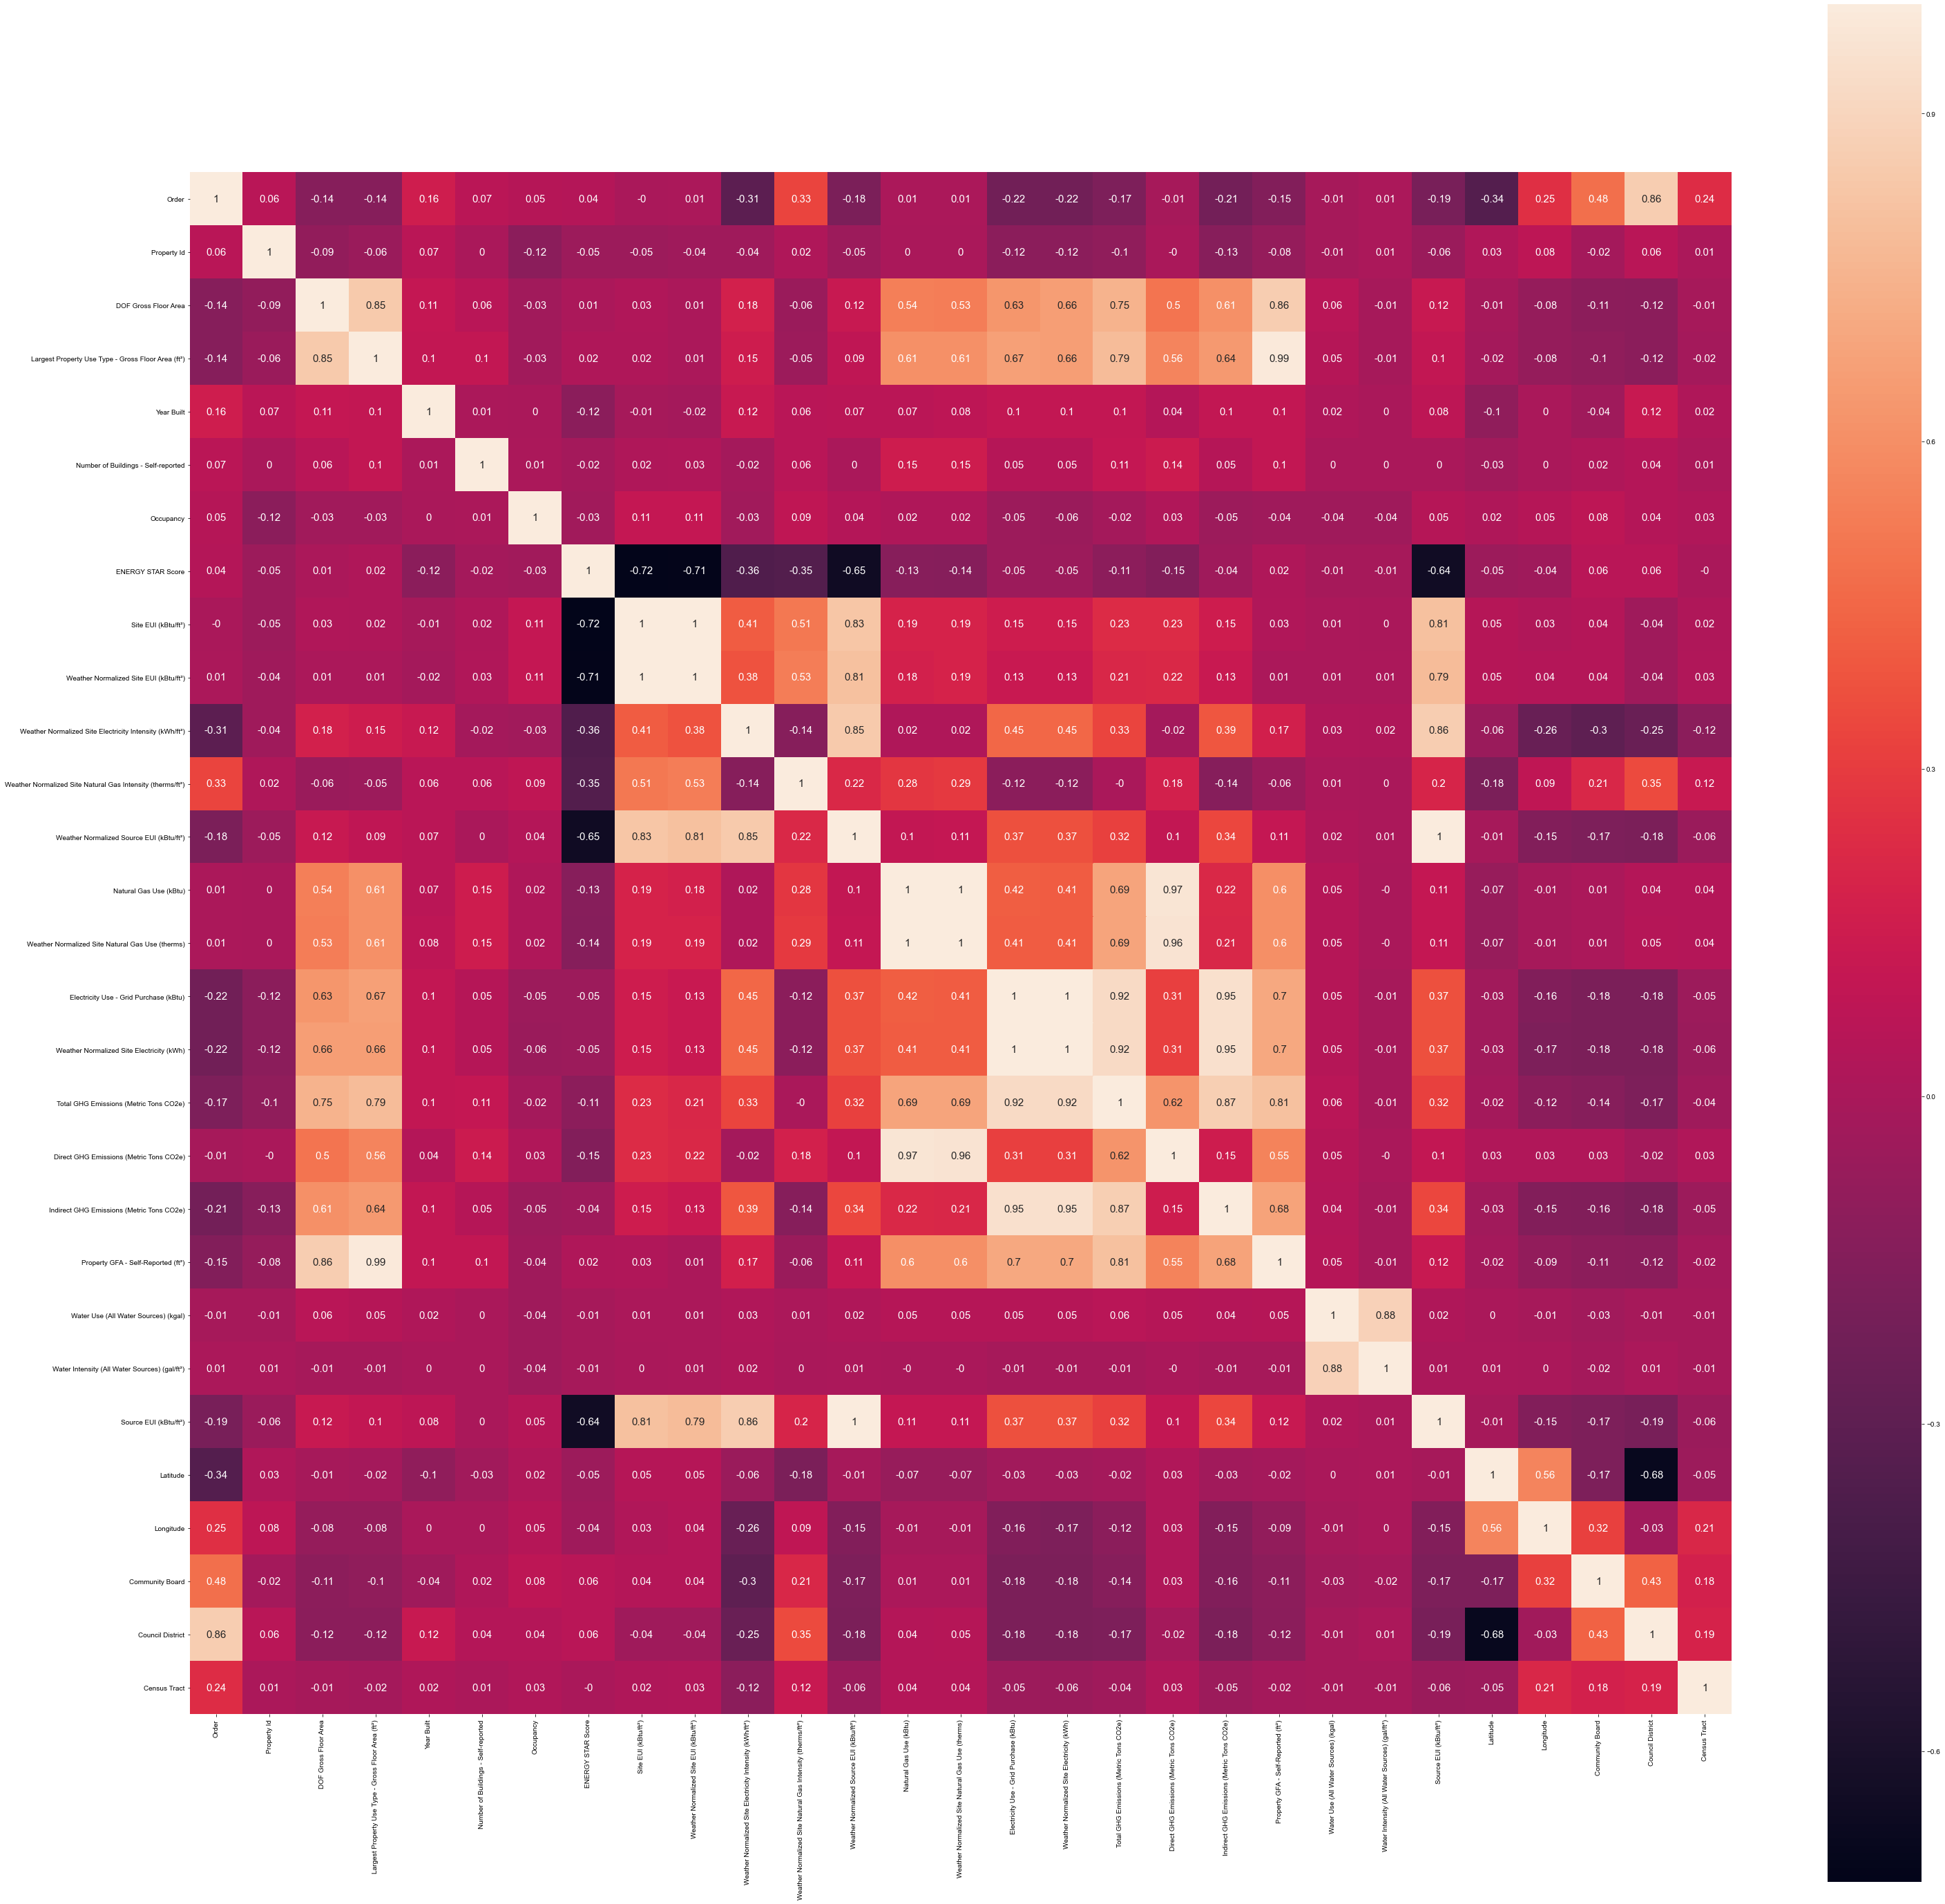

In [13]:
plt.figure(figsize=(50, 50))
sns.heatmap(round(df.corr(), 2), annot=True, square=True,annot_kws={"size": 15})
sns.set(font_scale=0.5)
plt.show()

As Noticed in EDA file, while performing EDA our target score has negative correlation relation with other attributes so we are adding log data for feature extraction

1. finding log features for those numeric attributes
2. one hot encoding categorical data which are high important for our target

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [722]:
#numeric data
num_data = df.select_dtypes(exclude='object')

In [723]:
n1=num_data.copy()
for col in n1.columns:
    if col == 'ENERGY STAR Score':
        next
    else:
        n1['sqrt_' + col] = np.sqrt(n1[col])
        n1['log_'+ col] = np.log(n1[col])

In [724]:
n1.drop([x for x in num_data.columns if x!='ENERGY STAR Score'],axis=1,inplace=True)

In [725]:
#categorical data
cat_data = df[['Borough', 'Largest Property Use Type']]

In [726]:
# One hot encode
cat_data = pd.get_dummies(cat_data)

In [727]:
df1 = pd.concat([n1, cat_data], axis = 1)

df1.shape

(11319, 110)

Lets remove collinear features as there are higher number of features as some of them are redundant

In [728]:
df2=df1.dropna(axis=1,how='all')
no_score = df2[df2['ENERGY STAR Score'].isna()]
score = df2[df2['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 108)
(9461, 108)


In [721]:
score.to_csv('data/training_data.csv',index=False)

In [729]:
features = score.drop(columns='ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Replacing the inf and -inf with nan (required for replacing nan values)(as these occures due to log transform)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Splitting into 70% training and 30% testing set
train_features, test_features, train_labels, test_labels = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(6622, 107)
(2839, 107)
(6622, 1)
(2839, 1)


In [730]:
X=train_features.apply(lambda x: x.fillna(x.median()),axis=0).values
X_test=test_features.apply(lambda x: x.fillna(x.median()),axis=0).values

Normalizing data

In [731]:
scaler = MinMaxScaler(feature_range=(0, 1))
#fitting and transform 
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [732]:
#converting into 1d array
y = train_labels.values.reshape((-1, ))
y_test = test_labels.values.reshape((-1, ))

In [733]:
# calculating mean absolute error
def mape(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

#creating function to perform model
def model_func(model):
    # Train the model
    model.fit(X, y)
    pred = model.predict(X_test)
    mape_res = mape(y_test, pred)
    return mape_res

In [734]:
#creating few models in a dict
models_li={'lr':LinearRegression(),'svm':SVR(C = 1000, gamma = 0.1),'randomforest':RandomForestRegressor(random_state=2020),'knn':KNeighborsRegressor(n_neighbors=10),'gradboost':GradientBoostingRegressor(random_state=2020),'ltb':ltb.LGBMRegressor(),'xgb':xg.XGBRegressor()}

In [735]:
mape_li={}
for i in models_li.keys():
    mae=model_func(models_li[i])
    mape_li[i]=mae

In [736]:
models_df=pd.DataFrame(mape_li.items()).rename(columns={0:'model_name',1:'MAPE_Result'})

In [737]:
models_df

,model_name,MAPE_Result
0,lr,12.325714
1,svm,10.065244
2,randomforest,8.962814
3,knn,13.045509
4,gradboost,9.087056
5,ltb,8.882567
6,xgb,8.975074


we can observe here light gbm performance is good compared with other models
so lets optimize model by choosing best hyperparameters

In [587]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [588]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

After adding lightgbm regression model,it performed good so again finding best hyperparameters for this model

In [670]:
lgbParams = {
    'n_estimators':[200,400,600,800,1000],
    'learning_rate': [0.02,0.04,0.06,0.08],
    'num_leaves': [5,10,15,20,25,30,35,40],
    'feature_fraction': [0.3,0.5,0.7,0.9],
    'bagging_fraction':[0.3,0.5,0.7,0.9],
    'bagging_freq': [10,20,30,40,50,60,70,80,90]
}

In [703]:
lgbr = ltb.LGBMRegressor()
lgbr_random1 = RandomizedSearchCV(estimator = lgbr, param_distributions = lgbParams,n_iter=200,cv = 3, random_state=42, n_jobs = -1)
lgbr_random1.fit(X, y)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                   param_distributions={'bagging_fraction': [0.3, 0.5, 0.7,
                                                            

In [660]:
def evaluate(model):
    pred = model.predict(X_test)
    mae = np.mean(abs(pred - y_test))
    print('MAE is {}'.format(mae))
    return mae

In [676]:
best_lgb=lgbr_random.best_estimator_
lgb_mae = evaluate(best_lgb)

MAE is 8.819984968437407


In [675]:
best_lgb

LGBMRegressor(bagging_fraction=0.9, bagging_freq=100, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.02, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=10, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [705]:
import joblib
# saving model
joblib.dump(best_lgb, 'data/lgb.pkl')
# load model
gbm_pickle = joblib.load('lgb.pkl')

In [671]:
best_random = rf_random.best_estimator_
best_random

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
mape_res.loc[len(mape_res)] = ['best_lgb',lgb_mae]

In [672]:
random_mae = evaluate(best_random)

MAE is 8.94686052076568
